# MNEflow basic calssification example

# 1. Importing data

### 1.1.from MNE epochs

If you use MNE-python, all you need is to provide your epochs file (or list of epoch files) to mneflow.produce_tfrecords


In [1]:
#%pylab inline
#get epochs using your mne-python pipeline
#import warnings
#warnings.filterwarnings("ignore", category=DeprecationWarning)
#warnings.filterwarnings("ignore", category=PendingDeprecationWarning)
#warnings.filterwarnings("ignore", category=FutureWarning)
#warnings.filterwarnings("ignore", category=RuntimeWarning)

import tensorflow as tf
#tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

import os
from time import time
import mne
from mne.datasets import multimodal
#os.chdir('/m/nbe/project/rtmeg/problearn/mneflow/')
os.chdir('/u/20/vranoug1/unix/OPM-BCI/mneflow-dev/mneflow/')
import mneflow

mne.set_log_level(verbose='CRITICAL')

fname_raw = os.path.join(multimodal.data_path(), 'multimodal_raw.fif')
raw = mne.io.read_raw_fif(fname_raw)

cond = raw.acqparser.get_condition(raw, None)
#get the list of condition names
condition_names = [k for c in cond for k,v in c['event_id'].items()]

epochs_list = [mne.Epochs(raw, **c) for c in cond]

#here we concatenate epochs because each input file contains just one condition
#otherwise mneflow.produce_tfrecords can handle a list of epochs objects
epochs = mne.concatenate_epochs(epochs_list)
#pick only planar gradiometers
epochs = epochs.pick_types(meg='grad')
#print(epochs.info)

In [11]:
import sys
sys.path
print('---------\n'+mneflow.__file__)
print('tf version: '+tf.__version__+'\n---------')

---------
/u/20/vranoug1/unix/.conda/envs/py3ml/lib/python3.7/site-packages/mneflow/__init__.py
tf version: 1.14.0
---------


### Convert epochs to TFRecord format

In [3]:
#Specify import options

import_opt = dict(savepath='../tfr/', #path where TFR files will be saved
                   out_name='mne_sample_epochs1', #name of TFRecords files
                   fs=600,
                   input_type='trials',
                   target_type='int',
                   picks = {'meg':'grad'},
                   scale=True, #apply baseline_scaling
                   crop_baseline=True, #remove baseline interval after scaling
                   decimate = 2,
                   scale_interval=(0,60), #indices in time axis corresponding to baseline interval
                   val_size=0.15, #validation set size set to 15% of all data
                   overwrite=True) 


#write TFRecord files and metadata file to disk
#meta = mneflow.produce_tfrecords([epochs],**import_opt)  
meta = mneflow.produce_tfrecords([epochs], **import_opt)  

processing epochs
input shape: (940, 204, 361)
target shape: (940,)
Prepocessed sample shape: (204, 151)
Target shape actual/metadata:  (8,) (8,)
Saving TFRecord# 0


## Other import options
### 1.2 Saved mne.epochs (*-epo.fif) files
Alternatively, if your epochs are saved to disk provide a str (or list of str) with path(s) to your -epo.fif files

e.g. this will work

```python
epochs.save('test_saved_epochs.fif')
meta = mneflow.produce_tfrecords('test_saved_epochs.fif',**opt)
```
### 1.3. Arrays in *.mat or *.npz format
if the first argument is str mneflow.produce_tfrecords can also accept *.mat or *.npz format

e.g.

```python
data_path = '/m/nbe/scratch/braindata/izbrv/detection_data/'
filenames = [data_path +'sub' + str(i) + '-grad.npz' for i in range(1,4)]
meta = mneflow.produce_tfrecords(filenames,**opt)
```
In this case, specify iput_type='array', and also provide array_keys keyword argument

e.g. 

```python
array_keys={'X':'my_data_samples','y':'my_labels'}
```

### 1.4. Tuple of (data, labels)
Finally, if you have a more complex preprocessing pipeline, you can feed you data and labels as a tuple of arrays

```python
X = epochs.get_data()
y = epochs.events[:,2]
meta = mneflow.produce_tfrecords((X,y),**opt)
```


# 2. Initialize the dataset object using the generated metadata file

The dataset object includes several methods that allow experimenting with the dataset without the need to repeat the preprocessing or overwriting the TFRecord files each time.

For example, you can train the model using any subset of classes, channels or reduce the sampling rate by decimating across the time domain.

In [4]:
dataset = mneflow.Dataset(meta, train_batch = 200, class_subset=None, pick_channels=None, decim=None)

W0130 14:34:41.738049 140378415892224 deprecation_wrapper.py:119] From /u/20/vranoug1/unix/.conda/envs/py3ml/lib/python3.7/site-packages/mneflow/data.py:158: The name tf.parse_single_example is deprecated. Please use tf.io.parse_single_example instead.

W0130 14:34:41.748973 140378415892224 deprecation.py:323] From /u/20/vranoug1/unix/.conda/envs/py3ml/lib/python3.7/site-packages/mneflow/data.py:120: tf_record_iterator (from tensorflow.python.lib.io.tf_record) is deprecated and will be removed in a future version.
Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


# 3. Choose from already implemented models

MNEflow pipeline consists of three major parts:
1. dataset
2. optimizer
3. computational graph

Each part has its own set of hyper-parameters and methods that can be tuned. See help for mneflow.Dataset
and mneflow.Optimizer and mneflow.models.Model for more details.
In this example will we use LF-CNN network


In [5]:
#specify optimizer parmeters
optimizer_params = dict(l1_lambda=3e-4,learn_rate=3e-4)

optimizer = mneflow.Optimizer(**optimizer_params)

In [6]:
#specify parameters specific to LF-CNN
lf_params = dict(n_ls=64, #number of latent factors
              filter_length=17, #convolutional filter length in time samples
              pooling = 5, #pooling factor
              stride = 5, #stride parameter for pooling layer
              padding = 'SAME',
              dropout = .5,
              nonlin = tf.nn.relu,
              pool_type = 'max',  
              model_path = import_opt['savepath']) #path for storing the saved model

#initialize the model using the dataset and optimizer objects, and the hyper-parameter dictionary
model = mneflow.models.LFCNN(dataset, optimizer, lf_params)

#this will initialize the iterators over the dataset,the computational graph and the optimizer
model.build()

W0130 14:34:41.944964 140378415892224 deprecation_wrapper.py:119] From /u/20/vranoug1/unix/.conda/envs/py3ml/lib/python3.7/site-packages/mneflow/models.py:68: The name tf.Session is deprecated. Please use tf.compat.v1.Session instead.

W0130 14:34:41.950569 140378415892224 deprecation_wrapper.py:119] From /u/20/vranoug1/unix/.conda/envs/py3ml/lib/python3.7/site-packages/mneflow/models.py:69: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0130 14:34:41.951752 140378415892224 deprecation.py:323] From /u/20/vranoug1/unix/.conda/envs/py3ml/lib/python3.7/site-packages/mneflow/models.py:93: DatasetV1.make_initializable_iterator (from tensorflow.python.data.ops.dataset_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `for ... in dataset:` to iterate over a dataset. If using `tf.estimator`, return the `Dataset` object directly from your input function. As a last resort, you can use `tf.compat.v1.data.make_initiali

X0: (?, 204, 151)
de-mix init : OK
dmx (?, 151, 1, 64)
lf-inp (?, 151, 1, 64)
conv init : OK
lf-inp (?, 151, 1, 64)
f: (17, 1, 64, 1)
lf-out (?, 31, 1, 64)
fc ::: 1984 8
fc init : OK
X: (?, 204, 151, 1)
y_pred: (?, 8)
L1 penalty applied to weights
Initialization complete!


In [7]:
#train the model
start = time()
model.train(n_iter=3000,eval_step=250,min_delta=1e-6,early_stopping=1)
stop = time() - start
print('Trained in {:.2f}s'.format(stop))

i 0, tr_loss 2.73335, tr_acc 0.11 v_loss 2.6457, v_acc 0.191489
i 250, tr_loss 1.10787, tr_acc 0.875 v_loss 1.31344, v_acc 0.755319
i 500, tr_loss 0.600252, tr_acc 0.99 v_loss 0.851781, v_acc 0.861702
i 750, tr_loss 0.442146, tr_acc 1 v_loss 0.755461, v_acc 0.893617
i 1000, tr_loss 0.429909, tr_acc 1 v_loss 0.683456, v_acc 0.904255
i 1250, tr_loss 0.395983, tr_acc 1 v_loss 0.654622, v_acc 0.914894
i 1500, tr_loss 0.364007, tr_acc 1 v_loss 0.5776, v_acc 0.904255
i 1750, tr_loss 0.332866, tr_acc 1 v_loss 0.523584, v_acc 0.93617
i 2000, tr_loss 0.300022, tr_acc 1 v_loss 0.515433, v_acc 0.925532
i 2250, tr_loss 0.275505, tr_acc 1 v_loss 0.425025, v_acc 0.93617


W0130 14:36:27.896053 140378415892224 deprecation.py:323] From /u/20/vranoug1/unix/.conda/envs/py3ml/lib/python3.7/site-packages/tensorflow/python/training/saver.py:1276: checkpoint_exists (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file APIs to check for files with this prefix.


* Patience count 1
early stopping...
stopped at: epoch 2500, val loss 0.425025, val acc 0.93617
Trained in 105.68s


# 4. Explore the trained model parameters
LFCNN allows to interpret the trained parameters in terms of toporaphies and the spectral properties of the latent sources contributing to each class. 

out_w: (1984, 8)
demx: (204, 64) kern: (17, 64) tc_out: (846, 31, 64) out_w: (31, 64, 8)
Maximum spearman r * weight: 0.05905036669434079
Maximum spearman r * weight: 0.10368995704467346
Maximum spearman r * weight: 0.07698678173899512
Maximum spearman r * weight: 0.06041586446355686
Maximum spearman r * weight: 0.07930963023067794
Maximum spearman r * weight: 0.1036029155249163
Maximum spearman r * weight: 0.054888957403190504
Maximum spearman r * weight: 0.07394518076707665


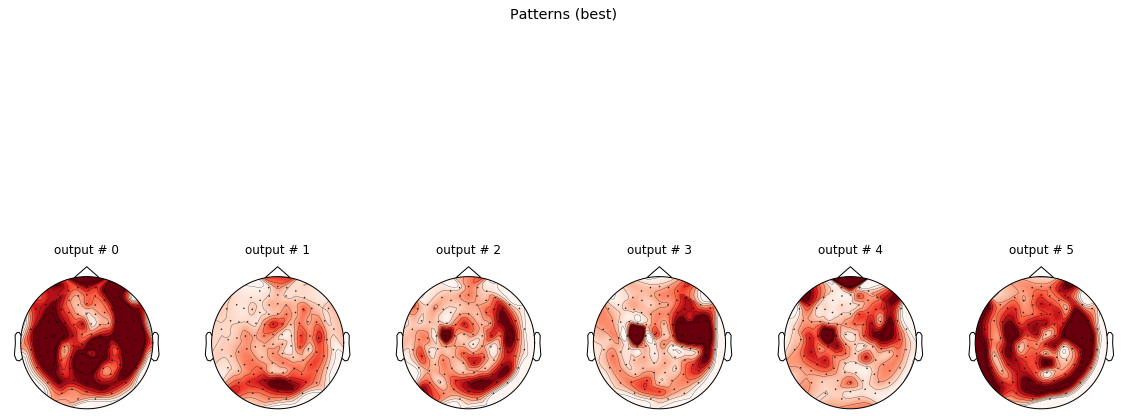

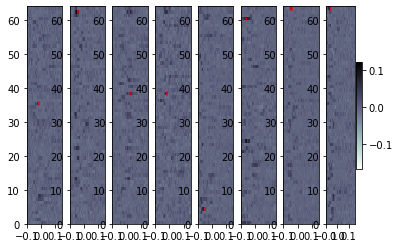

In [8]:

model.compute_patterns(data_path=meta['train_paths'], output='patterns')
f = model.plot_patterns(sensor_layout='Vectorview-grad', sorting='best', scale=False)


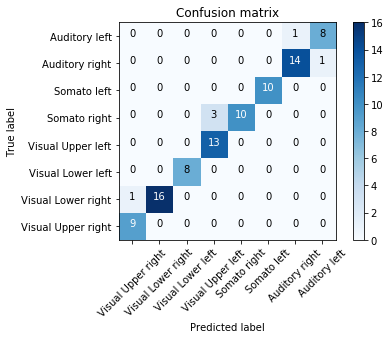

In [9]:
#Plotting the confusion matrix allows to identify analyze whether cetrain classes 
#are systematically harder to classify 
f2 = model.plot_cm(dataset='validation', class_names=condition_names)

Maximum spearman r * weight: 0.05905036669434079
Maximum spearman r * weight: 0.10368995704467346
Maximum spearman r * weight: 0.07698678173899512
Maximum spearman r * weight: 0.06041586446355686
Maximum spearman r * weight: 0.07930963023067794
Maximum spearman r * weight: 0.1036029155249163
Maximum spearman r * weight: 0.054888957403190504
Maximum spearman r * weight: 0.07394518076707665


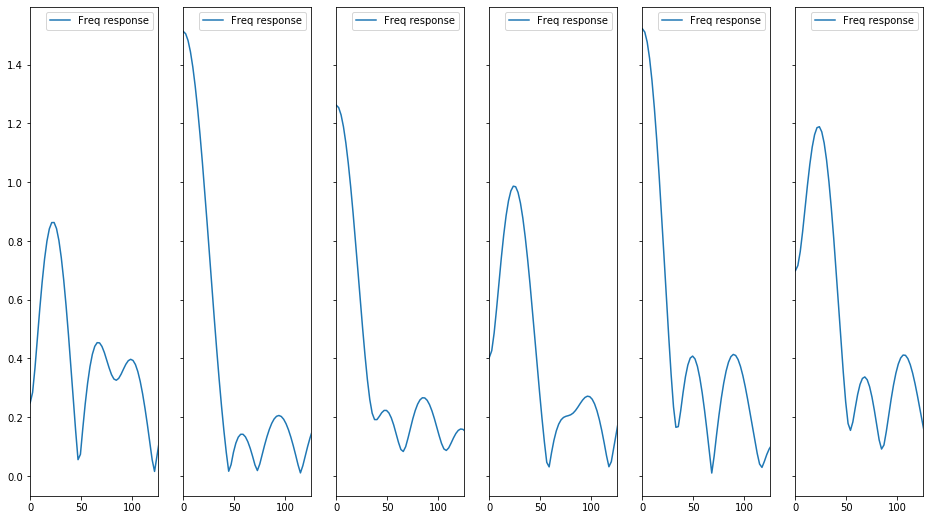

In [10]:
f3 = model.plot_spectra(sorting='best')